Data source: https://www.kaggle.com/chandramoulinaidu/spam-classification-for-basic-nlp

This data consists of raw mail messages with 3 columns which are:

1. Category: specifies whether mail is spam or not. 1 stands for spam and 0 otherwise.
2. Message: Raw text messages.
3. File_name: Unique message indicators.

Our goals is to make a machine learning model to predict whether a mail is spam or not.

In [39]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import joblib
import lightgbm as lgb
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Prepare the nltk
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Import the data
df = pd.read_csv("/content/drive/MyDrive/Personal Project/Python - Spam Email Classification/Spam Email raw text for NLP.csv")
df

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6
...,...,...,...
5791,0,"I'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5792,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",01127.841233b48eceb74a825417d8d918abf8
5794,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",01178.5c977dff972cd6eef64d4173b90307f0


From the data set above, we can see that we just need the first two columns for our goals which are the CATEGORY and MESSAGE columns.

In [4]:
# Identify the number of spam emails
df["CATEGORY"].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


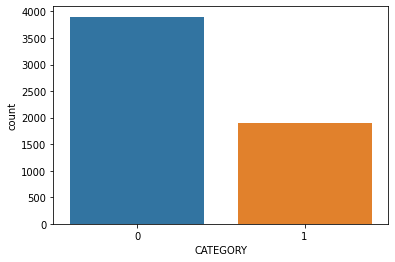

In [5]:
# Identify the number of spam emails using barplot
sns.countplot(df["CATEGORY"])

From the barplot we can clearly see that the data is unbalance. Mails that is not categorize as spam has higher number than the spam emails. But, for this particular project we don't need to process the data to be a balance dataset for each email category.

In [6]:
# Check if there are missing values in the data
df.isna().sum()

CATEGORY     0
MESSAGE      0
FILE_NAME    0
dtype: int64

Fortunately, there are no missing values in the data. So we can use the data as it is.

In [7]:
# Check the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CATEGORY   5796 non-null   int64 
 1   MESSAGE    5796 non-null   object
 2   FILE_NAME  5796 non-null   object
dtypes: int64(1), object(2)
memory usage: 136.0+ KB


In this project, we will use two approaches to quantify the text data which are using the bag of words and TF-IDF techniques. For the model, we only use three kinds of machine learning models which are logistic regression, random forest classifier, and light gradient boosting machine (LGBM) classifier to predict whether a mail is spam or not.

## Bag of Words

In [9]:
# Create a tokenizer
tokenizer = nltk.RegexpTokenizer(r"\w+")

# Create a lemmatizer
lemmatizer = WordNetLemmatizer()

# Save stopwords for english
stopwords = stopwords.words("english")

In [10]:
# Create a function to convert a string into token
def message_to_token_list(s):

  # Tokenize
  tokens = tokenizer.tokenize(s)

  # Lowecase
  lowercased_tokens = [t.lower() for t in tokens]

  # Lemmatize
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]

  # Filtering stopwords and save the result in a list
  useful_tokens = [t for t in lemmatized_tokens if t not in stopwords]

  return useful_tokens

In [11]:
# Split the data into train and test set

# Shuffle the data
df_shuffle = df.sample(frac = 1, random_state = 1)
df_shuffle = df_shuffle.reset_index(drop = True)

# Create a splitter for dividing the data
split_index = int(len(df_shuffle) * 0.8)

# Split the data
train_df, test_df = df_shuffle.iloc[:split_index, :-1], df_shuffle.iloc[split_index:, :-1]

In [12]:
# Create a token counter
def token_counter_calculator(series):
  token_counter = {}

  for message in series:
    message_as_token_list = message_to_token_list(message)

    for token in message_as_token_list:
      if token in token_counter:
        token_counter[token] += 1
      else:
        token_counter[token] = 1
  
  return token_counter

In [13]:
# Calculate the token counter
token_counter = token_counter_calculator(train_df["MESSAGE"])
len(token_counter)

86415

In [14]:
token_counter

{'html': 4175,
 'font': 35005,
 'back': 1055,
 'ffffff': 2535,
 'style': 3349,
 'background': 789,
 'color': 9642,
 'size': 13107,
 '3': 3581,
 'ptsize': 450,
 '12': 985,
 'b': 12856,
 'viagra': 66,
 '000000': 1923,
 '2': 7993,
 '10': 2182,
 'family': 1491,
 'sansserif': 314,
 'face': 9950,
 'arial': 6187,
 'lang': 419,
 '0': 9445,
 'br': 16013,
 'breakthrough': 22,
 'medication': 50,
 'impotence': 13,
 'delivered': 79,
 'mailbox': 71,
 'without': 658,
 'leaving': 50,
 'computer': 640,
 'simply': 377,
 'click': 2144,
 'href': 3875,
 'http': 14926,
 'host': 158,
 '1bulk': 12,
 'email': 4015,
 'software': 1129,
 'com': 11675,
 'ch4': 12,
 'pharm': 12,
 'blue': 181,
 'le': 680,
 '5': 2932,
 'minute': 366,
 'complete': 403,
 'line': 1307,
 'consultation': 68,
 'many': 1004,
 'case': 681,
 '24': 575,
 'nbsp': 9732,
 'hour': 589,
 'gt': 108,
 'website': 488,
 'treatment': 33,
 'compromised': 12,
 'sexual': 120,
 'function': 202,
 'convenient': 36,
 'affordable': 55,
 'confidential': 135,
 's

In [15]:
# Create a function to keep tokens based on the threshold
def keep_token(processed_token, threshold):
  if processed_token not in token_counter:
    return False
  else:
    return token_counter[processed_token] > threshold

In [16]:
# Define the features based on the keep tokens with threshold of 10k appearances
features = set()

for token in token_counter:
  if keep_token(token, 10000):
    features.add(token)

In [17]:
features

{'3d', 'b', 'br', 'com', 'font', 'http', 'p', 'size', 'td', 'tr'}

In [18]:
features = list(features)

In [19]:
features

['b', 'br', 'http', 'tr', 'p', 'size', '3d', 'td', 'font', 'com']

In [20]:
token_to_index_mapping = {feat:ind for feat, ind in zip(features, range(len(features)))}

In [23]:
# Count each of the features for each email message
def message_to_count_vector(message):
  count_vector = np.zeros(len(features))
  processed_list_of_tokens = message_to_token_list(message)

  for token in processed_list_of_tokens:
    if token not in features:
      continue
    index = token_to_index_mapping[token]
    count_vector[index] += 1
  
  return count_vector

In [22]:
# Create a function to determine features and target variable
def X_y(data):
  y = data["CATEGORY"].to_numpy().astype(int)

  message_col = data["MESSAGE"]
  count_vectors = []

  for message in message_col:
    count_vector = message_to_count_vector(message)
    count_vectors.append(count_vector)
  
  X = np.array(count_vectors).astype(int)

  return X, y

In [24]:
X_train, y_train = X_y(train_df)

In [25]:
X_test, y_test = X_y(test_df)

In [26]:
# MinMax scaling
scaler = MinMaxScaler().fit(X_train)

X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

### Logistic Regression

In [27]:
# Train fit for logistic regression
lr = LogisticRegression().fit(X_train, y_train)
print(classification_report(y_train, lr.predict(X_train)))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87      3112
           1       0.99      0.37      0.54      1524

    accuracy                           0.79      4636
   macro avg       0.88      0.68      0.70      4636
weighted avg       0.84      0.79      0.76      4636



In [28]:
# Test-logistic regression
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       788
           1       0.99      0.32      0.48       372

    accuracy                           0.78      1160
   macro avg       0.87      0.66      0.67      1160
weighted avg       0.83      0.78      0.74      1160



### Random Forest Classifier

In [29]:
# Train fit for random forest classifier
rf = RandomForestClassifier().fit(X_train, y_train)
print(classification_report(y_train, rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3112
           1       0.96      0.62      0.75      1524

    accuracy                           0.87      4636
   macro avg       0.90      0.80      0.83      4636
weighted avg       0.88      0.87      0.86      4636



In [30]:
# Test-random forest classifier
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       788
           1       0.89      0.57      0.70       372

    accuracy                           0.84      1160
   macro avg       0.86      0.77      0.79      1160
weighted avg       0.85      0.84      0.83      1160



### LGBM Classifier

In [31]:
# Train fit for lgbm classifier
lgbc = lgb.LGBMClassifier().fit(X_train, y_train)
print(classification_report(y_train, lgbc.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      0.99      0.91      3112
           1       0.97      0.59      0.74      1524

    accuracy                           0.86      4636
   macro avg       0.90      0.79      0.82      4636
weighted avg       0.88      0.86      0.85      4636



In [32]:
# Test-lgbm classifier
print(classification_report(y_test, lgbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.98      0.90       788
           1       0.95      0.56      0.70       372

    accuracy                           0.85      1160
   macro avg       0.88      0.77      0.80      1160
weighted avg       0.86      0.85      0.83      1160



### Calculate AUC for each of the model using the test data

In [33]:
# Calculate AUC for each model
roc_auc_logistic = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
roc_auc_randomforest = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
roc_auc_lgbm = roc_auc_score(y_test, lgbc.predict_proba(X_test)[:,1])

roc_auc_logistic, roc_auc_randomforest, roc_auc_lgbm

(0.7590708749522406, 0.868607062933246, 0.8726870803995413)

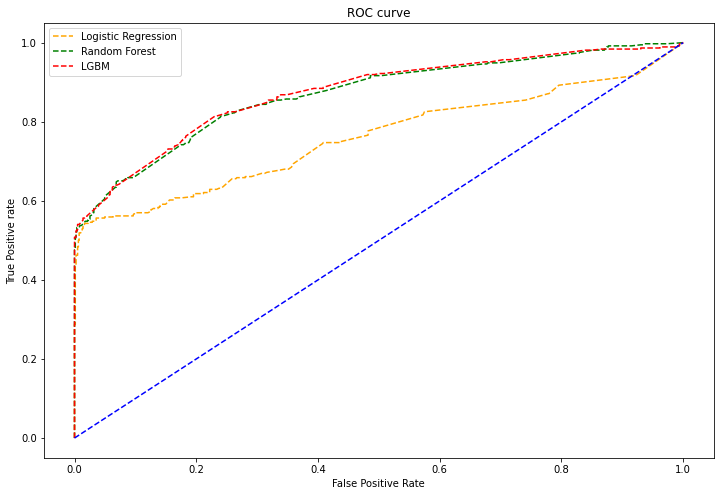

In [34]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label = 1)
fpr2, tpr2, thresh2 = roc_curve(y_test, rf.predict_proba(X_test)[:,1], pos_label = 1)
fpr3, tpr3, thresh3 = roc_curve(y_test, lgbc.predict_proba(X_test)[:,1], pos_label = 1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label = 1)

plt.figure(figsize = (12, 8))
# plot roc curves
plt.plot(fpr1, tpr1, linestyle = '--', color = 'orange', label = 'Logistic Regression')
plt.plot(fpr2, tpr2, linestyle = '--', color = 'green', label = 'Random Forest')
plt.plot(fpr3, tpr3, linestyle = '--', color = 'red', label = 'LGBM')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc = 'best')
plt.savefig('ROC', dpi = 300)
plt.show()

As you can see from each performance metric that the LGBM Classifier has greater result to classify a spam email.

## TF-IDF Version

For the TF-IDF version, we will use LGBM Classifier.

In [35]:
# Tfidf train data
corpus_train = []

for i in train_df["MESSAGE"]:
  message = ' '.join(message_to_token_list(i))
  corpus_train.append(message)

tfidf = TfidfVectorizer(ngram_range = (1, 3))
X_train = tfidf.fit_transform(corpus_train)
y_train = train_df["CATEGORY"]

# Tfidf test data
corpus_test = []

for i in test_df["MESSAGE"]:
  message = ' '.join(message_to_token_list(i))
  corpus_test.append(message)

X_test = tfidf.transform(corpus_test)
y_test = test_df["CATEGORY"]

In [36]:
# lgbm classifier
lgbc = lgb.LGBMClassifier().fit(X_train, y_train)
print(classification_report(y_train, lgbc.predict(X_train)))

print(classification_report(y_test, lgbc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3112
           1       1.00      1.00      1.00      1524

    accuracy                           1.00      4636
   macro avg       1.00      1.00      1.00      4636
weighted avg       1.00      1.00      1.00      4636

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       788
           1       0.98      0.98      0.98       372

    accuracy                           0.99      1160
   macro avg       0.99      0.99      0.99      1160
weighted avg       0.99      0.99      0.99      1160



In [37]:
# AUC
roc_auc_lgbm = roc_auc_score(y_test, lgbc.predict_proba(X_test)[:,1])
print(roc_auc_lgbm)

0.9986525025926533


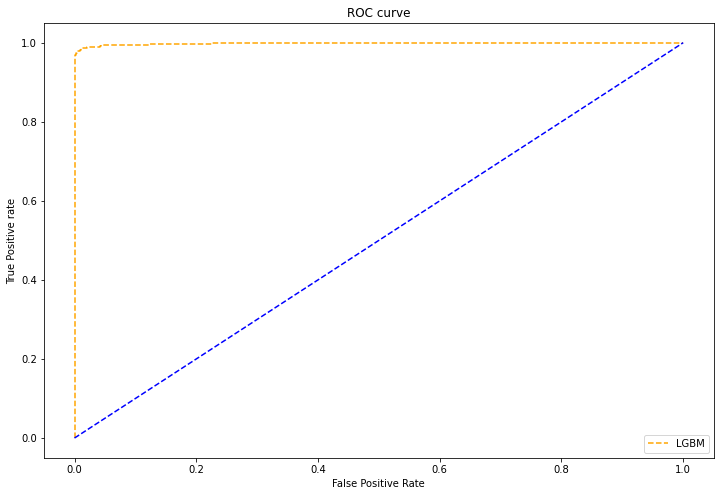

In [38]:
# roc curve for models
fpr, tpr, thresh = roc_curve(y_test, lgbc.predict_proba(X_test)[:,1], pos_label = 1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label = 1)

plt.figure(figsize = (12, 8))
# plot roc curves
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label = 'LGBM')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc = 'best')
# plt.savefig('ROC', dpi = 300)
plt.show()

It seems that our model which is LGBM Classifier has a nearly perfect metric performance while using the TF-IDF version of the email messages. Therefore, we can use this particular model to predict a spam email.

In [40]:
# Save model
joblib.dump(lgbc, "/content/drive/MyDrive/Personal Project/Python - Spam Email Classification/LGBM model.pkl")

['/content/drive/MyDrive/Personal Project/Python - Spam Email Classification/LGBM model.pkl']